In [1]:
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset
import os
import json

class MultiTaskDataset(Dataset):
    def __init__(self, label_dir, image_dir, transform=None):
        self.label_dir = label_dir
        self.image_dir = image_dir
        self.transform = transform
        self.data = []

        label_folders = sorted(os.listdir(label_dir))
        image_folders = sorted(os.listdir(image_dir))

        for label_folder, image_folder in zip(label_folders, image_folders):
            label_subdir = os.path.join(label_dir, label_folder)
            image_subdir = os.path.join(image_dir, image_folder)

            if os.path.isdir(label_subdir) and os.path.isdir(image_subdir):
                for file in os.listdir(label_subdir):
                    if file.endswith(".json"):
                        json_path = os.path.join(label_subdir, file)
                        with open(json_path, "r") as f:
                            try:
                                data = json.load(f)
                                image_filename = f"{data['filename']}.{data['format']}"
                                image_path = os.path.join(image_subdir, image_filename)

                                if os.path.exists(image_path):
                                    data["image_path"] = image_path
                                    self.data.append(data)
                                else:
                                    print(f"Image not found: {image_path}")
                            except json.JSONDecodeError as e:
                                print(f"Error loading JSON {json_path}: {e}")

        print(f"Total samples loaded: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item["image_path"]
        image = Image.open(image_path).convert("RGB")  # Load image as PIL.Image

        if self.transform:
            image = self.transform(image)  # Transform to tensor

        age = torch.tensor(item["age_past"], dtype=torch.float32)
        gender = torch.tensor(0 if item["gender"] == "male" else 1, dtype=torch.float32)

        return image, age, gender


# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기와 맞추기
    transforms.ToTensor(),         # PIL 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화
])

image_dir = "/home/hyun/dev_ws/ROS_project/age/Training/images"
label_dir = "/home/hyun/dev_ws/ROS_project/age/Training/labels"

# 데이터셋 생성
dataset = MultiTaskDataset(label_dir, image_dir, transform=transform)

# DataLoader 생성
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 데이터 확인
for images, ages, genders in dataloader:
    print(f"Image batch shape: {images.shape}")  # [batch_size, channels, height, width]
    print(f"Age batch: {ages}")
    print(f"Gender batch: {genders}")
    break


Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000050_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000048_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000049_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_15_00000005_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_06_00000046_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_36_00000038_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_25_00000019_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_19_00000009_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_19_00000012_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_004

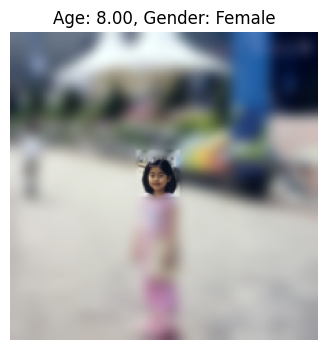

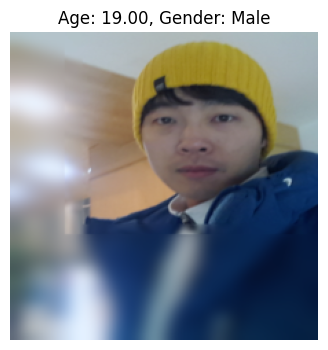

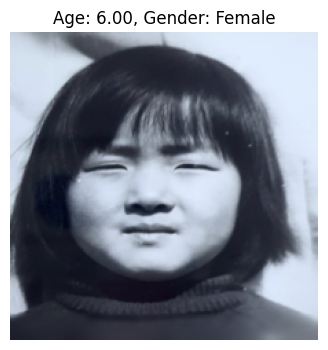

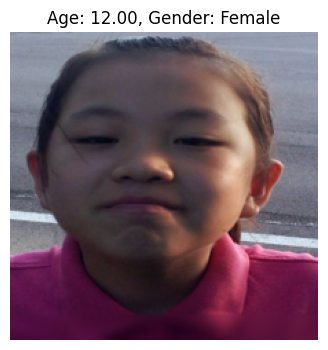

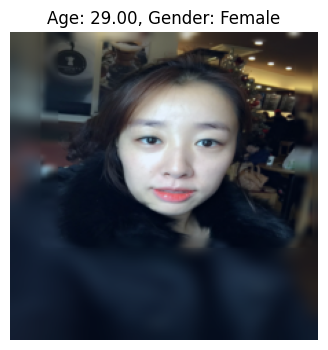

In [2]:
import random
import matplotlib.pyplot as plt

# 랜덤 샘플링 및 시각화 함수
def visualize_random_samples(dataloader, num_samples=5):
    # DataLoader에서 한 배치 가져오기
    images, ages, genders = next(iter(dataloader))

    # 랜덤으로 num_samples 개 샘플 선택
    indices = random.sample(range(len(images)), num_samples)

    for idx in indices:
        image = images[idx].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
        image = (image - image.min()) / (image.max() - image.min())  # Normalize된 데이터 조정
        age = ages[idx].item()
        gender = "Male" if genders[idx].item() == 0 else "Female"

        # 시각화
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"Age: {age:.2f}, Gender: {gender}")
        plt.axis('off')
        plt.show()

# 랜덤 샘플 시각화 실행
visualize_random_samples(dataloader, num_samples=5)


In [3]:
from sklearn.model_selection import train_test_split

# 데이터셋 전체를 리스트로 저장
data_indices = list(range(len(dataset)))

# Train(80%) / Temp(20%) 나누기
train_indices, temp_indices = train_test_split(data_indices, test_size=0.2, random_state=42)

# Temp 데이터를 Validation(10%) / Test(10%)로 나누기
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

print(f"Train size: {len(train_indices)}, Validation size: {len(val_indices)}, Test size: {len(test_indices)}")


Train size: 32000, Validation size: 4000, Test size: 4000


In [4]:
from torch.utils.data import Subset

# Subset 생성
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18
import numpy as np
from sklearn.metrics import accuracy_score
from torchvision import transforms
import cv2
from PIL import Image
from tqdm import tqdm

class AgeNormalizer:
    def __init__(self, min_age=0, max_age=100):
        self.min_age = min_age
        self.max_age = max_age
    
    def normalize(self, age):
        return (age - self.min_age) / (self.max_age - self.min_age)
    
    def denormalize(self, normalized_age):
        return normalized_age * (self.max_age - self.min_age) + self.min_age

class AgeLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
        
    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        diff_loss = torch.mean(torch.abs(pred - target))
        return mse_loss + self.alpha * diff_loss

class ImprovedGenderAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ImprovedGenderAgeModel, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.shared_fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512)  # Add BatchNorm for better training stability
        )
        
        self.age_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Normalize age output to [0,1]
        )
        
        self.gender_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(256),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.shared_fc(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        return age, gender

# 향상된 데이터 증강
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Larger size for cropping
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def calculate_metrics(pred_ages, true_ages, pred_genders, true_genders):
    age_mae = np.mean(np.abs(pred_ages - true_ages))
    age_mse = np.mean((pred_ages - true_ages) ** 2)
    age_acc_5 = np.mean(np.abs(pred_ages - true_ages) <= 5)  # ±5 years accuracy
    gender_acc = accuracy_score(true_genders, pred_genders)
    
    return {
        'age_mae': age_mae,
        'age_mse': age_mse,
        'age_acc_5': age_acc_5,
        'gender_acc': gender_acc
    }

def train_epoch(model, train_loader, optimizer, device, age_normalizer, age_weight=1.0, gender_weight=1.0):
    model.train()
    total_loss = 0
    age_preds, age_trues = [], []
    gender_preds, gender_trues = [], []
    
    pbar = tqdm(train_loader, desc='Training')
    for images, ages, genders in pbar:
        images = images.to(device)
        ages = torch.tensor([age_normalizer.normalize(age) for age in ages]).float().to(device)
        genders = genders.float().to(device)

        optimizer.zero_grad()
        age_output, gender_output = model(images)
        
        age_loss = AgeLoss()(age_output.squeeze(), ages) * age_weight
        gender_loss = nn.BCEWithLogitsLoss()(gender_output.squeeze(), genders) * gender_weight
        loss = age_loss + gender_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Store predictions for metrics
        age_preds.extend([age_normalizer.denormalize(age.item()) for age in age_output])
        age_trues.extend([age_normalizer.denormalize(age.item()) for age in ages])
        gender_preds.extend(torch.sigmoid(gender_output).squeeze().cpu().detach().numpy() > 0.5)
        gender_trues.extend(genders.cpu().numpy())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    metrics = calculate_metrics(np.array(age_preds), np.array(age_trues),
                              np.array(gender_preds), np.array(gender_trues))
    
    return total_loss / len(train_loader), metrics

def validate(model, val_loader, device, age_normalizer, age_weight=1.0, gender_weight=1.0):
    model.eval()
    total_loss = 0
    age_preds, age_trues = [], []
    gender_preds, gender_trues = [], []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for images, ages, genders in pbar:
            images = images.to(device)
            ages = torch.tensor([age_normalizer.normalize(age) for age in ages]).float().to(device)
            genders = genders.float().to(device)

            age_output, gender_output = model(images)
            
            age_loss = AgeLoss()(age_output.squeeze(), ages) * age_weight
            gender_loss = nn.BCEWithLogitsLoss()(gender_output.squeeze(), genders) * gender_weight
            loss = age_loss + gender_loss
            
            total_loss += loss.item()
            
            age_preds.extend([age_normalizer.denormalize(age.item()) for age in age_output])
            age_trues.extend([age_normalizer.denormalize(age.item()) for age in ages])
            gender_preds.extend(torch.sigmoid(gender_output).squeeze().cpu().numpy() > 0.5)
            gender_trues.extend(genders.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    metrics = calculate_metrics(np.array(age_preds), np.array(age_trues),
                              np.array(gender_preds), np.array(gender_trues))
    
    return total_loss / len(val_loader), metrics

# 학습 실행 코드
def train_model(train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = ImprovedGenderAgeModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    age_normalizer = AgeNormalizer()
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_metrics': [], 'val_metrics': []
    }
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, device, age_normalizer
        )
        
        val_loss, val_metrics = validate(
            model, val_loader, device, age_normalizer
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)
        
        # Print metrics
        print(f"\nTrain - Loss: {train_loss:.4f}")
        print(f"Train Metrics: {train_metrics}")
        print(f"Val - Loss: {val_loss:.4f}")
        print(f"Val Metrics: {val_metrics}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_gender_age_model.pth')
            epochs_without_improvement = 0
            print("New best model saved!")
        else:
            epochs_without_improvement += 1
            
        # Early stopping
        if epochs_without_improvement >= 10:
            print("Early stopping triggered")
            break
    
    torch.save(history, 'training_history.pth')
    return model, history

In [6]:
def resume_training(train_loader, val_loader, checkpoint_path='best_gender_age_model.pth', 
                   history_path='training_history.pth', final_model_path='final_gender_age_model.pth',
                   remaining_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 모델 초기화 및 이전 weights 불러오기
    model = ImprovedGenderAgeModel().to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded model weights from {checkpoint_path}")
    
    # 이전 학습 히스토리 불러오기
    try:
        history = torch.load(history_path)
        print(f"Loaded training history from {history_path}")
        start_epoch = len(history['train_loss'])
    except FileNotFoundError:
        print("No previous history found, starting fresh history")
        history = {
            'train_loss': [], 'val_loss': [],
            'train_metrics': [], 'val_metrics': []
        }
        start_epoch = 0
    
    # optimizer와 scheduler 재설정
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    age_normalizer = AgeNormalizer()
    
    # 최근 validation loss 확인
    best_val_loss = min(history['val_loss']) if history['val_loss'] else float('inf')
    epochs_without_improvement = 0
    
    total_epochs = start_epoch + remaining_epochs
    print(f"Resuming training from epoch {start_epoch + 1} to {total_epochs}")
    
    for epoch in range(start_epoch, total_epochs):
        print(f"\nEpoch {epoch+1}/{total_epochs}")
        
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, device, age_normalizer
        )
        
        val_loss, val_metrics = validate(
            model, val_loader, device, age_normalizer
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)
        
        # Print metrics
        print(f"\nTrain - Loss: {train_loss:.4f}")
        print(f"Train Metrics: {train_metrics}")
        print(f"Val - Loss: {val_loss:.4f}")
        print(f"Val Metrics: {val_metrics}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            epochs_without_improvement = 0
            print("New best model saved!")
        else:
            epochs_without_improvement += 1
            
        # 주기적으로 히스토리 저장
        if (epoch + 1) % 5 == 0:
            torch.save(history, history_path)
            print(f"Saved training history at epoch {epoch + 1}")
        
        # Early stopping
        if epochs_without_improvement >= 10:
            print("Early stopping triggered")
            break
    
    # 최종 모델 상태 저장
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model state to {final_model_path}")
    
    # 최종 히스토리 저장
    torch.save(history, history_path)
    return model, history

In [7]:
model, history = resume_training(
    train_loader, 
    val_loader,
    checkpoint_path='best_gender_age_model.pth',  # 이전에 저장된 모델 파일
    history_path='training_history.pth',          # 이전 학습 히스토리 파일
    remaining_epochs=10                           # 추가로 학습할 에폭 수
)

Using device: cuda


/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_4774/1665549394.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Loaded model weights from best_gender_age_model.pth
No previous history found, starting fresh history
Resuming training from epoch 1 to 10

Epoch 1/10


Training:  68%|██████▊   | 340/500 [24:31<11:18,  4.24s/it, loss=0.4106]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:11<00:00,  3.99s/it, loss=0.5742]



Train - Loss: 0.4078
Train Metrics: {'age_mae': np.float64(10.416259743648698), 'age_mse': np.float64(182.64350996467653), 'age_acc_5': np.float64(0.31359375), 'gender_acc': 0.85203125}
Val - Loss: 0.4217
Val Metrics: {'age_mae': np.float64(9.825652663316578), 'age_mse': np.float64(159.5565690294522), 'age_acc_5': np.float64(0.32175), 'gender_acc': 0.84325}
New best model saved!

Epoch 2/10


Training:  51%|█████     | 255/500 [18:08<15:41,  3.84s/it, loss=0.3914]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:11<00:00,  4.00s/it, loss=0.6762]



Train - Loss: 0.3473
Train Metrics: {'age_mae': np.float64(9.490301839017775), 'age_mse': np.float64(156.5347205664203), 'age_acc_5': np.float64(0.35971875), 'gender_acc': 0.87903125}
Val - Loss: 0.4018
Val Metrics: {'age_mae': np.float64(9.635197772271932), 'age_mse': np.float64(155.1745839608814), 'age_acc_5': np.float64(0.334), 'gender_acc': 0.85925}
New best model saved!

Epoch 3/10


Training:  91%|█████████ | 453/500 [32:05<03:37,  4.63s/it, loss=0.4210]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:12<00:00,  4.01s/it, loss=0.4737]



Train - Loss: 0.3113
Train Metrics: {'age_mae': np.float64(9.002794055716368), 'age_mse': np.float64(141.97105173941586), 'age_acc_5': np.float64(0.380625), 'gender_acc': 0.89309375}
Val - Loss: 0.3822
Val Metrics: {'age_mae': np.float64(8.886306224716828), 'age_mse': np.float64(134.0176505329737), 'age_acc_5': np.float64(0.374), 'gender_acc': 0.86375}
New best model saved!

Epoch 4/10


Training:  98%|█████████▊| 492/500 [34:21<00:31,  3.93s/it, loss=0.3393]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:07<00:00,  3.93s/it, loss=0.6110]



Train - Loss: 0.2776
Train Metrics: {'age_mae': np.float64(8.895705080439075), 'age_mse': np.float64(140.2303470043121), 'age_acc_5': np.float64(0.39284375), 'gender_acc': 0.9100625}
Val - Loss: 0.3828
Val Metrics: {'age_mae': np.float64(8.85567012350075), 'age_mse': np.float64(128.41188398751547), 'age_acc_5': np.float64(0.3585), 'gender_acc': 0.869}

Epoch 5/10


Training:  52%|█████▏    | 262/500 [17:49<16:40,  4.21s/it, loss=0.2783]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.90s/it, loss=0.3633]



Train - Loss: 0.2395
Train Metrics: {'age_mae': np.float64(8.636393245213549), 'age_mse': np.float64(133.23526779341046), 'age_acc_5': np.float64(0.4063125), 'gender_acc': 0.9263125}
Val - Loss: 0.3739
Val Metrics: {'age_mae': np.float64(8.578944249800406), 'age_mse': np.float64(127.20952088000733), 'age_acc_5': np.float64(0.385), 'gender_acc': 0.8725}
New best model saved!
Saved training history at epoch 5

Epoch 6/10


Training:  79%|███████▉  | 396/500 [26:45<07:01,  4.05s/it, loss=0.1463]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:06<00:00,  3.91s/it, loss=0.5721]



Train - Loss: 0.2028
Train Metrics: {'age_mae': np.float64(8.290760367404436), 'age_mse': np.float64(123.93212083297077), 'age_acc_5': np.float64(0.4238125), 'gender_acc': 0.94440625}
Val - Loss: 0.3938
Val Metrics: {'age_mae': np.float64(8.292502776160836), 'age_mse': np.float64(120.21350834732772), 'age_acc_5': np.float64(0.41075), 'gender_acc': 0.86425}

Epoch 7/10


Training:  32%|███▏      | 159/500 [10:44<21:30,  3.78s/it, loss=0.1990]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:04<00:00,  3.88s/it, loss=0.7567]



Train - Loss: 0.1777
Train Metrics: {'age_mae': np.float64(8.156056543451268), 'age_mse': np.float64(120.20119585789172), 'age_acc_5': np.float64(0.43034375), 'gender_acc': 0.95228125}
Val - Loss: 0.4691
Val Metrics: {'age_mae': np.float64(8.396490233946206), 'age_mse': np.float64(134.89568913652795), 'age_acc_5': np.float64(0.4375), 'gender_acc': 0.85525}

Epoch 8/10


Training:  30%|██▉       | 149/500 [09:53<25:51,  4.42s/it, loss=0.1705]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.89s/it, loss=0.4417]



Train - Loss: 0.1544
Train Metrics: {'age_mae': np.float64(7.999019503890304), 'age_mse': np.float64(115.18884201319356), 'age_acc_5': np.float64(0.43334375), 'gender_acc': 0.9625625}
Val - Loss: 0.4213
Val Metrics: {'age_mae': np.float64(8.069098511147649), 'age_mse': np.float64(121.27070558023924), 'age_acc_5': np.float64(0.45), 'gender_acc': 0.8805}

Epoch 9/10


Training:  86%|████████▌ | 429/500 [28:51<04:58,  4.21s/it, loss=0.1732]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:06<00:00,  3.91s/it, loss=0.6403]



Train - Loss: 0.1433
Train Metrics: {'age_mae': np.float64(7.875061010496575), 'age_mse': np.float64(112.86447608244396), 'age_acc_5': np.float64(0.44178125), 'gender_acc': 0.96709375}
Val - Loss: 0.4786
Val Metrics: {'age_mae': np.float64(8.961229924159124), 'age_mse': np.float64(156.99067612564144), 'age_acc_5': np.float64(0.442), 'gender_acc': 0.86575}

Epoch 10/10


Training:  29%|██▊       | 143/500 [09:40<27:10,  4.57s/it, loss=0.1399]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:19<00:00,  4.11s/it, loss=0.6490]


Train - Loss: 0.1246
Train Metrics: {'age_mae': np.float64(7.721869502423215), 'age_mse': np.float64(108.79611961403955), 'age_acc_5': np.float64(0.454), 'gender_acc': 0.97328125}
Val - Loss: 0.5170
Val Metrics: {'age_mae': np.float64(8.135083168532583), 'age_mse': np.float64(126.60930177170083), 'age_acc_5': np.float64(0.4475), 'gender_acc': 0.86375}
Saved training history at epoch 10


In [8]:
model, history = resume_training(
    train_loader, 
    val_loader,
    checkpoint_path='best_gender_age_model.pth',    # 베스트 모델 저장 경로
    final_model_path='final_gender_age_model.pth',  # 최종 모델 저장 경로
    history_path='training_history.pth',            # 학습 히스토리 저장 경로
    remaining_epochs=80
)

Using device: cuda


/tmp/ipykernel_162600/1182971949.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
/tmp/ipykernel_162600/1182971949.py:1

Loaded model weights from best_gender_age_model.pth
Loaded training history from training_history.pth
Resuming training from epoch 11 to 20

Epoch 11/20


Training:  54%|█████▎    | 268/500 [18:17<15:48,  4.09s/it, loss=0.1545]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.90s/it, loss=0.7982]



Train - Loss: 0.2014
Train Metrics: {'age_mae': np.float64(8.353052478768223), 'age_mse': np.float64(125.28012619979785), 'age_acc_5': np.float64(0.41803125), 'gender_acc': 0.944}
Val - Loss: 0.4963
Val Metrics: {'age_mae': np.float64(8.829834641190246), 'age_mse': np.float64(153.0344669806278), 'age_acc_5': np.float64(0.4495), 'gender_acc': 0.84275}

Epoch 12/20


Training:  21%|██        | 105/500 [06:58<26:17,  3.99s/it, loss=0.3126]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:04<00:00,  3.88s/it, loss=0.8160]



Train - Loss: 0.1721
Train Metrics: {'age_mae': np.float64(8.092255284565908), 'age_mse': np.float64(118.62068687365652), 'age_acc_5': np.float64(0.43375), 'gender_acc': 0.95425}
Val - Loss: 0.5405
Val Metrics: {'age_mae': np.float64(9.11352133185137), 'age_mse': np.float64(137.86819366056966), 'age_acc_5': np.float64(0.36725), 'gender_acc': 0.84475}

Epoch 13/20


Training:   7%|▋         | 35/500 [02:20<32:56,  4.25s/it, loss=0.2198]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.90s/it, loss=0.7775]



Train - Loss: 0.1520
Train Metrics: {'age_mae': np.float64(8.106262586197408), 'age_mse': np.float64(117.83593707736547), 'age_acc_5': np.float64(0.42759375), 'gender_acc': 0.96421875}
Val - Loss: 0.4933
Val Metrics: {'age_mae': np.float64(8.1643520589103), 'age_mse': np.float64(123.14219971998179), 'age_acc_5': np.float64(0.44225), 'gender_acc': 0.86075}

Epoch 14/20


Training:  66%|██████▌   | 331/500 [22:20<11:25,  4.06s/it, loss=0.1886]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:06<00:00,  3.92s/it, loss=0.5105]



Train - Loss: 0.1386
Train Metrics: {'age_mae': np.float64(8.007733317420934), 'age_mse': np.float64(116.67899542207266), 'age_acc_5': np.float64(0.43734375), 'gender_acc': 0.9685625}
Val - Loss: 0.4781
Val Metrics: {'age_mae': np.float64(8.26741679822444), 'age_mse': np.float64(118.2716036684194), 'age_acc_5': np.float64(0.41525), 'gender_acc': 0.8625}

Epoch 15/20


Training:  42%|████▏     | 209/500 [14:07<19:01,  3.92s/it, loss=0.1342]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:07<00:00,  3.93s/it, loss=0.5474]



Train - Loss: 0.1466
Train Metrics: {'age_mae': np.float64(8.332454928169318), 'age_mse': np.float64(124.86776107912473), 'age_acc_5': np.float64(0.4215625), 'gender_acc': 0.96546875}
Val - Loss: 0.5038
Val Metrics: {'age_mae': np.float64(8.704398130532354), 'age_mse': np.float64(126.85728681480502), 'age_acc_5': np.float64(0.37375), 'gender_acc': 0.86575}
Saved training history at epoch 15

Epoch 16/20


Training:  59%|█████▉    | 297/500 [20:18<13:16,  3.93s/it, loss=0.1657]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.89s/it, loss=0.3729]



Train - Loss: 0.1162
Train Metrics: {'age_mae': np.float64(7.831331172649516), 'age_mse': np.float64(112.24161737889527), 'age_acc_5': np.float64(0.45321875), 'gender_acc': 0.97634375}
Val - Loss: 0.6518
Val Metrics: {'age_mae': np.float64(8.2621489133453), 'age_mse': np.float64(122.25873198913223), 'age_acc_5': np.float64(0.42975), 'gender_acc': 0.84125}

Epoch 17/20


Training:  15%|█▌        | 75/500 [05:06<27:17,  3.85s/it, loss=0.0674]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.89s/it, loss=0.7806]



Train - Loss: 0.1126
Train Metrics: {'age_mae': np.float64(7.684366143710212), 'age_mse': np.float64(108.35795708455043), 'age_acc_5': np.float64(0.45621875), 'gender_acc': 0.97684375}
Val - Loss: 0.5350
Val Metrics: {'age_mae': np.float64(8.213923969981261), 'age_mse': np.float64(117.8653807399986), 'age_acc_5': np.float64(0.417), 'gender_acc': 0.87275}

Epoch 18/20


Training:  22%|██▏       | 110/500 [07:27<26:33,  4.09s/it, loss=0.1189]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:04<00:00,  3.88s/it, loss=0.7437]



Train - Loss: 0.1055
Train Metrics: {'age_mae': np.float64(7.44346982994175), 'age_mse': np.float64(102.43740757346039), 'age_acc_5': np.float64(0.47346875), 'gender_acc': 0.97878125}
Val - Loss: 0.5823
Val Metrics: {'age_mae': np.float64(7.9138770596007815), 'age_mse': np.float64(121.60248079275604), 'age_acc_5': np.float64(0.467), 'gender_acc': 0.8625}

Epoch 19/20


Training:  96%|█████████▌| 478/500 [32:17<01:33,  4.26s/it, loss=0.0691]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:03<00:00,  3.87s/it, loss=1.1478]



Train - Loss: 0.1276
Train Metrics: {'age_mae': np.float64(8.241255377113703), 'age_mse': np.float64(123.69997728944082), 'age_acc_5': np.float64(0.42775), 'gender_acc': 0.97384375}
Val - Loss: 0.5619
Val Metrics: {'age_mae': np.float64(8.289296568895224), 'age_mse': np.float64(135.5468693765882), 'age_acc_5': np.float64(0.4605), 'gender_acc': 0.86325}

Epoch 20/20


Training:  61%|██████▏   | 307/500 [20:50<13:21,  4.15s/it, loss=0.0784]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.89s/it, loss=0.6274]


Train - Loss: 0.1014
Train Metrics: {'age_mae': np.float64(7.714118687728478), 'age_mse': np.float64(109.48101937324637), 'age_acc_5': np.float64(0.4559375), 'gender_acc': 0.98153125}
Val - Loss: 0.5078
Val Metrics: {'age_mae': np.float64(9.022305506211705), 'age_mse': np.float64(135.0519239936109), 'age_acc_5': np.float64(0.366), 'gender_acc': 0.871}
Saved training history at epoch 20
Early stopping triggered
Saved final model state to final_gender_age_model.pth


In [7]:
def validate(model, val_loader, device, age_normalizer, age_weight=1.0, gender_weight=1.0):
    model.eval()
    total_loss = 0
    total_age_loss = 0
    total_gender_loss = 0  # gender loss 추적
    age_preds, age_trues = [], []
    gender_preds, gender_trues = [], []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for images, ages, genders in pbar:
            images = images.to(device)
            ages = torch.tensor([age_normalizer.normalize(age) for age in ages]).float().to(device)
            genders = genders.float().to(device)

            age_output, gender_output = model(images)
            
            age_loss = AgeLoss()(age_output.squeeze(), ages) * age_weight
            gender_loss = nn.BCEWithLogitsLoss()(gender_output.squeeze(), genders) * gender_weight
            loss = age_loss + gender_loss
            
            total_loss += loss.item()
            total_age_loss += age_loss.item()
            total_gender_loss += gender_loss.item()  # gender loss 누적
            
            age_preds.extend([age_normalizer.denormalize(age.item()) for age in age_output])
            age_trues.extend([age_normalizer.denormalize(age.item()) for age in ages])
            gender_preds.extend(torch.sigmoid(gender_output).squeeze().cpu().numpy() > 0.5)
            gender_trues.extend(genders.cpu().numpy())
            
            # progress bar에 두 loss 모두 표시
            pbar.set_postfix({
                'total_loss': f'{loss.item():.4f}',
                'age_loss': f'{age_loss.item():.4f}',
                'gender_loss': f'{gender_loss.item():.4f}'
            })
    
    metrics = calculate_metrics(np.array(age_preds), np.array(age_trues),
                              np.array(gender_preds), np.array(gender_trues))
    
    return (total_loss / len(val_loader), 
            total_age_loss / len(val_loader), 
            total_gender_loss / len(val_loader),  # gender loss 반환
            metrics)

def resume_training(train_loader, val_loader, checkpoint_path='best_gender_age_model.pth', 
                   history_path='training_history.pth', final_model_path='final_gender_age_model.pth',
                   remaining_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = ImprovedGenderAgeModel().to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded model weights from {checkpoint_path}")
    
    # 기본 히스토리 구조 정의
    default_history = {
        'train_loss': [], 
        'val_loss': [], 
        'val_age_loss': [],
        'val_gender_loss': [],
        'train_metrics': [], 
        'val_metrics': []
    }
    
    try:
        loaded_history = torch.load(history_path)
        print(f"Loaded training history from {history_path}")
        
        # 기존 히스토리의 키들을 새로운 구조에 맞게 변환
        history = default_history.copy()
        for key in loaded_history:
            if key in history:
                history[key] = loaded_history[key]
        
        # 누락된 키가 있다면 빈 리스트로 초기화
        for key in default_history:
            if not history.get(key):
                history[key] = []
                print(f"Initialized missing history key: {key}")
        
        start_epoch = len(history['train_loss'])
        
    except FileNotFoundError:
        print("No previous history found, starting fresh history")
        history = default_history
        start_epoch = 0
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    age_normalizer = AgeNormalizer()
    
    # 안전하게 best loss 값 설정
    best_val_age_loss = float('inf')
    if history['val_age_loss']:
        best_val_age_loss = min(history['val_age_loss'])
    
    epochs_without_improvement = 0
    total_epochs = start_epoch + remaining_epochs
    print(f"Resuming training from epoch {start_epoch + 1} to {total_epochs}")
    
    for epoch in range(start_epoch, total_epochs):
        print(f"\nEpoch {epoch+1}/{total_epochs}")
        
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, device, age_normalizer
        )
        
        val_loss, val_age_loss, val_gender_loss, val_metrics = validate(
            model, val_loader, device, age_normalizer
        )
        
        scheduler.step(val_age_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_age_loss'].append(val_age_loss)
        history['val_gender_loss'].append(val_gender_loss)  # gender loss 저장
        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)
        
        # Print all metrics and losses
        print(f"\nTrain - Total Loss: {train_loss:.4f}")
        print(f"Train Metrics: {train_metrics}")
        print(f"Validation Losses:")
        print(f"  - Total Loss: {val_loss:.4f}")
        print(f"  - Age Loss: {val_age_loss:.4f}")
        print(f"  - Gender Loss: {val_gender_loss:.4f}")  # gender loss 출력
        print(f"Val Metrics: {val_metrics}")
        
        # Save best model based on age loss
        if val_age_loss < best_val_age_loss:
            best_val_age_loss = val_age_loss
            torch.save(model.state_dict(), checkpoint_path)
            epochs_without_improvement = 0
            print(f"New best model saved! (Age Loss: {val_age_loss:.4f}, Gender Loss: {val_gender_loss:.4f})")
        else:
            epochs_without_improvement += 1
            
        if (epoch + 1) % 5 == 0:
            torch.save(history, history_path)
            print(f"Saved training history at epoch {epoch + 1}")
        
        if epochs_without_improvement >= 10:
            print("Early stopping triggered (no improvement in Age Loss)")
            break
    
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model state to {final_model_path}")
    
    torch.save(history, history_path)
    return model, history

In [13]:
model, history = resume_training(
    train_loader, 
    val_loader,
    checkpoint_path='best_gender_age_model.pth',    # 베스트 모델 저장 경로
    final_model_path='final_gender_age_model.pth',  # 최종 모델 저장 경로
    history_path='training_history.pth',            # 학습 히스토리 저장 경로
    remaining_epochs=80
)

Using device: cuda


/tmp/ipykernel_162600/141548911.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
/tmp/ipykernel_162600/141548911.py:67

Loaded model weights from best_gender_age_model.pth
Loaded training history from training_history.pth
Initialized missing history key: val_age_loss
Initialized missing history key: val_gender_loss
Resuming training from epoch 21 to 100

Epoch 21/100


Training:  28%|██▊       | 139/500 [10:39<25:41,  4.27s/it, loss=0.1538]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:45<00:00,  4.53s/it, total_loss=0.5928, age_loss=0.0577, gender_loss=0.5351]



Train - Total Loss: 0.2047
Train Metrics: {'age_mae': np.float64(8.401089834833693), 'age_mse': np.float64(126.36347034046176), 'age_acc_5': np.float64(0.417125), 'gender_acc': 0.9413125}
Validation Losses:
  - Total Loss: 0.4036
  - Age Loss: 0.0521
  - Gender Loss: 0.3516
Val Metrics: {'age_mae': np.float64(8.052766650752165), 'age_mse': np.float64(117.50767362019003), 'age_acc_5': np.float64(0.4355), 'gender_acc': 0.86025}
New best model saved! (Age Loss: 0.0521, Gender Loss: 0.3516)

Epoch 22/100


Training:  95%|█████████▌| 476/500 [33:38<01:38,  4.11s/it, loss=0.1469]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=0.4183, age_loss=0.0496, gender_loss=0.3687]



Train - Total Loss: 0.1772
Train Metrics: {'age_mae': np.float64(8.276102741034993), 'age_mse': np.float64(123.35703457621142), 'age_acc_5': np.float64(0.425375), 'gender_acc': 0.953125}
Validation Losses:
  - Total Loss: 0.4358
  - Age Loss: 0.0539
  - Gender Loss: 0.3818
Val Metrics: {'age_mae': np.float64(8.39043236669968), 'age_mse': np.float64(120.03757752232123), 'age_acc_5': np.float64(0.39), 'gender_acc': 0.86925}

Epoch 23/100


Training:  90%|████████▉ | 448/500 [31:22<03:34,  4.13s/it, loss=0.1577]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=0.5883, age_loss=0.0576, gender_loss=0.5308]



Train - Total Loss: 0.1517
Train Metrics: {'age_mae': np.float64(8.122058891721826), 'age_mse': np.float64(119.12092672206994), 'age_acc_5': np.float64(0.43134375), 'gender_acc': 0.96459375}
Validation Losses:
  - Total Loss: 0.4542
  - Age Loss: 0.0543
  - Gender Loss: 0.3999
Val Metrics: {'age_mae': np.float64(8.251153855241137), 'age_mse': np.float64(130.56645955010384), 'age_acc_5': np.float64(0.4535), 'gender_acc': 0.86325}

Epoch 24/100


Training:  65%|██████▍   | 323/500 [22:30<11:54,  4.03s/it, loss=0.2697]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.05s/it, total_loss=0.4805, age_loss=0.0477, gender_loss=0.4328]



Train - Total Loss: 0.1402
Train Metrics: {'age_mae': np.float64(7.8827561261125085), 'age_mse': np.float64(114.04684397643963), 'age_acc_5': np.float64(0.44728125), 'gender_acc': 0.9675}
Validation Losses:
  - Total Loss: 0.6571
  - Age Loss: 0.0535
  - Gender Loss: 0.6036
Val Metrics: {'age_mae': np.float64(8.23531571055899), 'age_mse': np.float64(123.33688266769104), 'age_acc_5': np.float64(0.4245), 'gender_acc': 0.82825}

Epoch 25/100


Training:  73%|███████▎  | 367/500 [25:38<09:35,  4.33s/it, loss=0.0917]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.05s/it, total_loss=0.5762, age_loss=0.0457, gender_loss=0.5305]



Train - Total Loss: 0.1316
Train Metrics: {'age_mae': np.float64(7.990017242831527), 'age_mse': np.float64(115.93442266033755), 'age_acc_5': np.float64(0.44009375), 'gender_acc': 0.97090625}
Validation Losses:
  - Total Loss: 0.5140
  - Age Loss: 0.0535
  - Gender Loss: 0.4605
Val Metrics: {'age_mae': np.float64(8.344377835432534), 'age_mse': np.float64(118.7129957109178), 'age_acc_5': np.float64(0.3995), 'gender_acc': 0.87475}
Saved training history at epoch 25

Epoch 26/100


Training:   0%|          | 1/500 [00:03<30:55,  3.72s/it, loss=0.0567]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=0.6330, age_loss=0.0545, gender_loss=0.5784]



Train - Total Loss: 0.1271
Train Metrics: {'age_mae': np.float64(8.330859346623765), 'age_mse': np.float64(124.57964046218692), 'age_acc_5': np.float64(0.42053125), 'gender_acc': 0.9739375}
Validation Losses:
  - Total Loss: 0.5243
  - Age Loss: 0.0543
  - Gender Loss: 0.4700
Val Metrics: {'age_mae': np.float64(8.486873906861973), 'age_mse': np.float64(118.46055942846692), 'age_acc_5': np.float64(0.381), 'gender_acc': 0.86925}

Epoch 27/100


Training:  83%|████████▎ | 414/500 [28:54<05:33,  3.88s/it, loss=0.2887]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:11<00:00,  3.99s/it, total_loss=0.9250, age_loss=0.0453, gender_loss=0.8797]



Train - Total Loss: 0.1268
Train Metrics: {'age_mae': np.float64(8.419807362927532), 'age_mse': np.float64(127.21550127840513), 'age_acc_5': np.float64(0.41421875), 'gender_acc': 0.9736875}
Validation Losses:
  - Total Loss: 0.5782
  - Age Loss: 0.0547
  - Gender Loss: 0.5235
Val Metrics: {'age_mae': np.float64(8.49674854173986), 'age_mse': np.float64(123.1181739175641), 'age_acc_5': np.float64(0.3915), 'gender_acc': 0.861}

Epoch 28/100


Training:  82%|████████▏ | 410/500 [28:43<06:56,  4.62s/it, loss=0.0501]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.06s/it, total_loss=0.7288, age_loss=0.0512, gender_loss=0.6777]



Train - Total Loss: 0.0733
Train Metrics: {'age_mae': np.float64(7.439560825402441), 'age_mse': np.float64(101.83881225934161), 'age_acc_5': np.float64(0.469875), 'gender_acc': 0.99196875}
Validation Losses:
  - Total Loss: 0.5531
  - Age Loss: 0.0503
  - Gender Loss: 0.5028
Val Metrics: {'age_mae': np.float64(7.804584403692034), 'age_mse': np.float64(112.92777694186128), 'age_acc_5': np.float64(0.457), 'gender_acc': 0.8755}
New best model saved! (Age Loss: 0.0503, Gender Loss: 0.5028)

Epoch 29/100


Training:  62%|██████▏   | 312/500 [21:39<12:30,  3.99s/it, loss=0.0482]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=0.8756, age_loss=0.0512, gender_loss=0.8244]



Train - Total Loss: 0.0547
Train Metrics: {'age_mae': np.float64(7.22800850700587), 'age_mse': np.float64(97.37257014042956), 'age_acc_5': np.float64(0.48371875), 'gender_acc': 0.99778125}
Validation Losses:
  - Total Loss: 0.6404
  - Age Loss: 0.0499
  - Gender Loss: 0.5905
Val Metrics: {'age_mae': np.float64(7.774981261354738), 'age_mse': np.float64(110.5408737153393), 'age_acc_5': np.float64(0.4545), 'gender_acc': 0.87575}
New best model saved! (Age Loss: 0.0499, Gender Loss: 0.5905)

Epoch 30/100


Training:  65%|██████▌   | 326/500 [22:50<12:20,  4.25s/it, loss=0.0501]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.05s/it, total_loss=0.9465, age_loss=0.0484, gender_loss=0.8981]



Train - Total Loss: 0.0497
Train Metrics: {'age_mae': np.float64(7.055632676061942), 'age_mse': np.float64(93.22816462287568), 'age_acc_5': np.float64(0.49721875), 'gender_acc': 0.99878125}
Validation Losses:
  - Total Loss: 0.6920
  - Age Loss: 0.0500
  - Gender Loss: 0.6419
Val Metrics: {'age_mae': np.float64(7.7916193766487565), 'age_mse': np.float64(110.81563257031816), 'age_acc_5': np.float64(0.45625), 'gender_acc': 0.8795}
Saved training history at epoch 30

Epoch 31/100


Training:  80%|████████  | 401/500 [27:59<06:07,  3.71s/it, loss=0.0375]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=0.9034, age_loss=0.0491, gender_loss=0.8543]



Train - Total Loss: 0.0461
Train Metrics: {'age_mae': np.float64(6.921814670557796), 'age_mse': np.float64(90.11108151316762), 'age_acc_5': np.float64(0.5033125), 'gender_acc': 0.9994375}
Validation Losses:
  - Total Loss: 0.7456
  - Age Loss: 0.0492
  - Gender Loss: 0.6964
Val Metrics: {'age_mae': np.float64(7.653427898900031), 'age_mse': np.float64(108.9164148459357), 'age_acc_5': np.float64(0.461), 'gender_acc': 0.877}
New best model saved! (Age Loss: 0.0492, Gender Loss: 0.6964)

Epoch 32/100


Training:  28%|██▊       | 140/500 [09:57<24:13,  4.04s/it, loss=0.0443]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.05s/it, total_loss=0.9064, age_loss=0.0479, gender_loss=0.8585]



Train - Total Loss: 0.0440
Train Metrics: {'age_mae': np.float64(6.754041253180185), 'age_mse': np.float64(86.30750495909079), 'age_acc_5': np.float64(0.51225), 'gender_acc': 0.99965625}
Validation Losses:
  - Total Loss: 0.7974
  - Age Loss: 0.0489
  - Gender Loss: 0.7485
Val Metrics: {'age_mae': np.float64(7.646686648432009), 'age_mse': np.float64(107.11941394322686), 'age_acc_5': np.float64(0.45875), 'gender_acc': 0.87725}
New best model saved! (Age Loss: 0.0489, Gender Loss: 0.7485)

Epoch 33/100


Training:   3%|▎         | 15/500 [01:06<35:42,  4.42s/it, loss=0.0402]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=0.9942, age_loss=0.0500, gender_loss=0.9441]



Train - Total Loss: 0.0442
Train Metrics: {'age_mae': np.float64(6.619977407701663), 'age_mse': np.float64(83.08179872144541), 'age_acc_5': np.float64(0.52125), 'gender_acc': 0.999375}
Validation Losses:
  - Total Loss: 0.8515
  - Age Loss: 0.0490
  - Gender Loss: 0.8025
Val Metrics: {'age_mae': np.float64(7.625819365087956), 'age_mse': np.float64(108.40985744590263), 'age_acc_5': np.float64(0.46575), 'gender_acc': 0.87325}

Epoch 34/100


Training:  67%|██████▋   | 333/500 [23:16<12:17,  4.42s/it, loss=0.0443]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=1.0394, age_loss=0.0487, gender_loss=0.9907]



Train - Total Loss: 0.0435
Train Metrics: {'age_mae': np.float64(6.45990590811125), 'age_mse': np.float64(79.39967949581525), 'age_acc_5': np.float64(0.53325), 'gender_acc': 0.99915625}
Validation Losses:
  - Total Loss: 0.8720
  - Age Loss: 0.0491
  - Gender Loss: 0.8229
Val Metrics: {'age_mae': np.float64(7.647368310959852), 'age_mse': np.float64(108.83257556215392), 'age_acc_5': np.float64(0.46325), 'gender_acc': 0.87075}

Epoch 35/100


Training:  85%|████████▌ | 426/500 [29:42<05:17,  4.29s/it, loss=0.0358]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=1.1986, age_loss=0.0486, gender_loss=1.1500]



Train - Total Loss: 0.0401
Train Metrics: {'age_mae': np.float64(6.298100868222536), 'age_mse': np.float64(76.09656065020062), 'age_acc_5': np.float64(0.5445625), 'gender_acc': 0.9996875}
Validation Losses:
  - Total Loss: 0.9243
  - Age Loss: 0.0487
  - Gender Loss: 0.8755
Val Metrics: {'age_mae': np.float64(7.575508754456181), 'age_mse': np.float64(108.67647929285745), 'age_acc_5': np.float64(0.46925), 'gender_acc': 0.8725}
New best model saved! (Age Loss: 0.0487, Gender Loss: 0.8755)
Saved training history at epoch 35

Epoch 36/100


Training:  93%|█████████▎| 465/500 [32:33<02:29,  4.27s/it, loss=0.0407]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=0.8995, age_loss=0.0475, gender_loss=0.8520]



Train - Total Loss: 0.0394
Train Metrics: {'age_mae': np.float64(6.150177613951382), 'age_mse': np.float64(72.8037451631322), 'age_acc_5': np.float64(0.55275), 'gender_acc': 0.99953125}
Validation Losses:
  - Total Loss: 0.9390
  - Age Loss: 0.0490
  - Gender Loss: 0.8900
Val Metrics: {'age_mae': np.float64(7.600238152071925), 'age_mse': np.float64(110.04708015423874), 'age_acc_5': np.float64(0.47175), 'gender_acc': 0.873}

Epoch 37/100


Training:  39%|███▉      | 196/500 [13:36<19:44,  3.90s/it, loss=0.0329]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=0.8419, age_loss=0.0469, gender_loss=0.7950]



Train - Total Loss: 0.0389
Train Metrics: {'age_mae': np.float64(5.969775022788963), 'age_mse': np.float64(68.48322525455991), 'age_acc_5': np.float64(0.5628125), 'gender_acc': 0.999375}
Validation Losses:
  - Total Loss: 0.9400
  - Age Loss: 0.0492
  - Gender Loss: 0.8908
Val Metrics: {'age_mae': np.float64(7.62915376368358), 'age_mse': np.float64(111.1872752523426), 'age_acc_5': np.float64(0.47775), 'gender_acc': 0.87425}

Epoch 38/100


Training:  59%|█████▉    | 295/500 [20:41<13:58,  4.09s/it, loss=0.0297]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.06s/it, total_loss=1.3761, age_loss=0.0487, gender_loss=1.3274]



Train - Total Loss: 0.0370
Train Metrics: {'age_mae': np.float64(5.831439398958173), 'age_mse': np.float64(65.66868116631446), 'age_acc_5': np.float64(0.5736875), 'gender_acc': 0.99965625}
Validation Losses:
  - Total Loss: 0.9845
  - Age Loss: 0.0488
  - Gender Loss: 0.9357
Val Metrics: {'age_mae': np.float64(7.5969937360501305), 'age_mse': np.float64(108.58131064525818), 'age_acc_5': np.float64(0.47), 'gender_acc': 0.8735}

Epoch 39/100


Training:  83%|████████▎ | 415/500 [29:01<06:21,  4.49s/it, loss=0.0402]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.03s/it, total_loss=1.1001, age_loss=0.0465, gender_loss=1.0535]



Train - Total Loss: 0.0367
Train Metrics: {'age_mae': np.float64(5.719371730135753), 'age_mse': np.float64(63.027424513631054), 'age_acc_5': np.float64(0.57996875), 'gender_acc': 0.9995}
Validation Losses:
  - Total Loss: 0.9690
  - Age Loss: 0.0494
  - Gender Loss: 0.9195
Val Metrics: {'age_mae': np.float64(7.689510802261884), 'age_mse': np.float64(110.22896030509119), 'age_acc_5': np.float64(0.465), 'gender_acc': 0.87725}

Epoch 40/100


Training:  56%|█████▋    | 282/500 [19:49<15:50,  4.36s/it, loss=0.0372]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=1.0285, age_loss=0.0455, gender_loss=0.9831]



Train - Total Loss: 0.0355
Train Metrics: {'age_mae': np.float64(5.5562377703608945), 'age_mse': np.float64(59.27995952980494), 'age_acc_5': np.float64(0.58740625), 'gender_acc': 0.999375}
Validation Losses:
  - Total Loss: 0.9936
  - Age Loss: 0.0491
  - Gender Loss: 0.9445
Val Metrics: {'age_mae': np.float64(7.627012651694872), 'age_mse': np.float64(110.0702567052074), 'age_acc_5': np.float64(0.47), 'gender_acc': 0.87075}
Saved training history at epoch 40

Epoch 41/100


Training:  52%|█████▏    | 261/500 [18:10<17:29,  4.39s/it, loss=0.0347]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=1.1447, age_loss=0.0465, gender_loss=1.0983]



Train - Total Loss: 0.0361
Train Metrics: {'age_mae': np.float64(5.434913217346184), 'age_mse': np.float64(57.15929723023307), 'age_acc_5': np.float64(0.60003125), 'gender_acc': 0.99925}
Validation Losses:
  - Total Loss: 0.9685
  - Age Loss: 0.0496
  - Gender Loss: 0.9189
Val Metrics: {'age_mae': np.float64(7.701333951109991), 'age_mse': np.float64(111.33058341623607), 'age_acc_5': np.float64(0.45975), 'gender_acc': 0.87425}

Epoch 42/100


Training:  64%|██████▍   | 322/500 [22:35<12:26,  4.20s/it, loss=0.0318]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.05s/it, total_loss=1.1235, age_loss=0.0469, gender_loss=1.0766]



Train - Total Loss: 0.0327
Train Metrics: {'age_mae': np.float64(5.250667320014327), 'age_mse': np.float64(53.43211210391871), 'age_acc_5': np.float64(0.615375), 'gender_acc': 0.99975}
Validation Losses:
  - Total Loss: 0.9678
  - Age Loss: 0.0493
  - Gender Loss: 0.9186
Val Metrics: {'age_mae': np.float64(7.645547343735805), 'age_mse': np.float64(110.47031180530487), 'age_acc_5': np.float64(0.4705), 'gender_acc': 0.87525}

Epoch 43/100


Training:  25%|██▌       | 126/500 [08:47<26:41,  4.28s/it, loss=0.0322]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:14<00:00,  4.04s/it, total_loss=1.1401, age_loss=0.0490, gender_loss=1.0912]



Train - Total Loss: 0.0321
Train Metrics: {'age_mae': np.float64(5.186918364724261), 'age_mse': np.float64(52.07488903960821), 'age_acc_5': np.float64(0.618375), 'gender_acc': 0.99975}
Validation Losses:
  - Total Loss: 0.9840
  - Age Loss: 0.0491
  - Gender Loss: 0.9349
Val Metrics: {'age_mae': np.float64(7.580548513296005), 'age_mse': np.float64(112.04109455679534), 'age_acc_5': np.float64(0.485), 'gender_acc': 0.876}

Epoch 44/100


Training:  64%|██████▍   | 320/500 [22:26<11:59,  3.99s/it, loss=0.0267]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.05s/it, total_loss=1.1003, age_loss=0.0477, gender_loss=1.0526]



Train - Total Loss: 0.0318
Train Metrics: {'age_mae': np.float64(5.1842190543509785), 'age_mse': np.float64(52.19966896605014), 'age_acc_5': np.float64(0.61753125), 'gender_acc': 0.99984375}
Validation Losses:
  - Total Loss: 0.9678
  - Age Loss: 0.0494
  - Gender Loss: 0.9183
Val Metrics: {'age_mae': np.float64(7.65885522980586), 'age_mse': np.float64(111.57581667955601), 'age_acc_5': np.float64(0.4685), 'gender_acc': 0.8755}

Epoch 45/100


Training:   7%|▋         | 36/500 [02:28<31:05,  4.02s/it, loss=0.0297]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:10<00:00,  3.98s/it, total_loss=1.1606, age_loss=0.0486, gender_loss=1.1120]


Train - Total Loss: 0.0313
Train Metrics: {'age_mae': np.float64(5.130950993443548), 'age_mse': np.float64(51.14005721554895), 'age_acc_5': np.float64(0.62203125), 'gender_acc': 0.99990625}
Validation Losses:
  - Total Loss: 0.9833
  - Age Loss: 0.0489
  - Gender Loss: 0.9344
Val Metrics: {'age_mae': np.float64(7.5709440073677134), 'age_mse': np.float64(109.98287437353038), 'age_acc_5': np.float64(0.47825), 'gender_acc': 0.8765}
Saved training history at epoch 45
Early stopping triggered (no improvement in Age Loss)
Saved final model state to final_gender_age_model.pth


In [8]:
model, history = resume_training(
    train_loader, 
    val_loader,
    checkpoint_path='best_gender_age_model.pth',    # 베스트 모델 저장 경로
    final_model_path='final_gender_age_model.pth',  # 최종 모델 저장 경로
    history_path='training_history.pth',            # 학습 히스토리 저장 경로
    remaining_epochs=20
)

Using device: cuda


/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_53742/141548911.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

Loaded model weights from best_gender_age_model.pth
Loaded training history from training_history.pth
Resuming training from epoch 46 to 65

Epoch 46/65


Training:  61%|██████    | 304/500 [21:55<12:55,  3.96s/it, loss=0.0791]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:16<00:00,  4.07s/it, total_loss=0.5879, age_loss=0.0577, gender_loss=0.5302]



Train - Total Loss: 0.0901
Train Metrics: {'age_mae': np.float64(7.1312813402953905), 'age_mse': np.float64(94.63342184600329), 'age_acc_5': np.float64(0.4868125), 'gender_acc': 0.9845}
Validation Losses:
  - Total Loss: 0.5768
  - Age Loss: 0.0516
  - Gender Loss: 0.5252
Val Metrics: {'age_mae': np.float64(7.949880349182058), 'age_mse': np.float64(118.07427345261438), 'age_acc_5': np.float64(0.4615), 'gender_acc': 0.86875}

Epoch 47/65


Training:  33%|███▎      | 165/500 [11:37<23:18,  4.17s/it, loss=0.0637]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:16<00:00,  4.08s/it, total_loss=1.1051, age_loss=0.0366, gender_loss=1.0685]



Train - Total Loss: 0.0898
Train Metrics: {'age_mae': np.float64(7.108722584566567), 'age_mse': np.float64(93.20333601402137), 'age_acc_5': np.float64(0.48490625), 'gender_acc': 0.98465625}
Validation Losses:
  - Total Loss: 0.6653
  - Age Loss: 0.0523
  - Gender Loss: 0.6130
Val Metrics: {'age_mae': np.float64(8.137977964361198), 'age_mse': np.float64(116.97582324116944), 'age_acc_5': np.float64(0.431), 'gender_acc': 0.858}

Epoch 48/65


Training:  10%|▉         | 48/500 [03:24<31:43,  4.21s/it, loss=0.0643]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.06s/it, total_loss=0.7326, age_loss=0.0478, gender_loss=0.6848]



Train - Total Loss: 0.0910
Train Metrics: {'age_mae': np.float64(7.112365865745232), 'age_mse': np.float64(93.55772750588376), 'age_acc_5': np.float64(0.4828125), 'gender_acc': 0.98378125}
Validation Losses:
  - Total Loss: 0.6755
  - Age Loss: 0.0533
  - Gender Loss: 0.6222
Val Metrics: {'age_mae': np.float64(8.182509854500177), 'age_mse': np.float64(124.5120148130227), 'age_acc_5': np.float64(0.44175), 'gender_acc': 0.86}

Epoch 49/65


Training:  26%|██▌       | 128/500 [09:07<25:40,  4.14s/it, loss=0.1301]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:16<00:00,  4.07s/it, total_loss=0.7413, age_loss=0.0425, gender_loss=0.6987]



Train - Total Loss: 0.0879
Train Metrics: {'age_mae': np.float64(7.09393949721707), 'age_mse': np.float64(92.37882675182132), 'age_acc_5': np.float64(0.48196875), 'gender_acc': 0.9854375}
Validation Losses:
  - Total Loss: 0.6036
  - Age Loss: 0.0505
  - Gender Loss: 0.5531
Val Metrics: {'age_mae': np.float64(7.878351122699678), 'age_mse': np.float64(111.92243496064434), 'age_acc_5': np.float64(0.4445), 'gender_acc': 0.86525}

Epoch 50/65


Training:  83%|████████▎ | 416/500 [29:07<05:43,  4.09s/it, loss=0.0631]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:16<00:00,  4.06s/it, total_loss=1.3385, age_loss=0.0461, gender_loss=1.2924]



Train - Total Loss: 0.0859
Train Metrics: {'age_mae': np.float64(7.008705722576996), 'age_mse': np.float64(91.02909023442298), 'age_acc_5': np.float64(0.4908125), 'gender_acc': 0.9851875}
Validation Losses:
  - Total Loss: 0.7272
  - Age Loss: 0.0520
  - Gender Loss: 0.6752
Val Metrics: {'age_mae': np.float64(7.998778575262986), 'age_mse': np.float64(120.23767385646418), 'age_acc_5': np.float64(0.4545), 'gender_acc': 0.839}
Saved training history at epoch 50

Epoch 51/65


Training:  14%|█▍        | 72/500 [05:04<32:24,  4.54s/it, loss=0.0479]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.06s/it, total_loss=0.9439, age_loss=0.0435, gender_loss=0.9004]



Train - Total Loss: 0.0810
Train Metrics: {'age_mae': np.float64(7.005222375091398), 'age_mse': np.float64(91.1645073803717), 'age_acc_5': np.float64(0.4913125), 'gender_acc': 0.98775}
Validation Losses:
  - Total Loss: 0.6240
  - Age Loss: 0.0522
  - Gender Loss: 0.5719
Val Metrics: {'age_mae': np.float64(8.08767058334779), 'age_mse': np.float64(117.98916387689064), 'age_acc_5': np.float64(0.43275), 'gender_acc': 0.86}

Epoch 52/65


Training:  18%|█▊        | 92/500 [06:31<30:19,  4.46s/it, loss=0.0650]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:17<00:00,  4.08s/it, total_loss=0.8035, age_loss=0.0506, gender_loss=0.7530]



Train - Total Loss: 0.0786
Train Metrics: {'age_mae': np.float64(6.8148090788861735), 'age_mse': np.float64(86.16728054606575), 'age_acc_5': np.float64(0.50296875), 'gender_acc': 0.98825}
Validation Losses:
  - Total Loss: 0.6437
  - Age Loss: 0.0509
  - Gender Loss: 0.5927
Val Metrics: {'age_mae': np.float64(7.84361912223469), 'age_mse': np.float64(117.12415005273179), 'age_acc_5': np.float64(0.46025), 'gender_acc': 0.86425}

Epoch 53/65


Training:  69%|██████▉   | 344/500 [24:16<10:55,  4.20s/it, loss=0.0531]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:17<00:00,  4.09s/it, total_loss=0.9969, age_loss=0.0542, gender_loss=0.9426]



Train - Total Loss: 0.0741
Train Metrics: {'age_mae': np.float64(6.675613440919551), 'age_mse': np.float64(83.10171341599865), 'age_acc_5': np.float64(0.51090625), 'gender_acc': 0.98878125}
Validation Losses:
  - Total Loss: 0.6740
  - Age Loss: 0.0534
  - Gender Loss: 0.6207
Val Metrics: {'age_mae': np.float64(8.262469841027633), 'age_mse': np.float64(120.58742546000543), 'age_acc_5': np.float64(0.409), 'gender_acc': 0.8535}

Epoch 54/65


Training:  82%|████████▏ | 409/500 [28:49<06:21,  4.19s/it, loss=0.0569]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:16<00:00,  4.07s/it, total_loss=1.0662, age_loss=0.0542, gender_loss=1.0119]



Train - Total Loss: 0.0784
Train Metrics: {'age_mae': np.float64(6.738654808863066), 'age_mse': np.float64(83.88734875159706), 'age_acc_5': np.float64(0.5046875), 'gender_acc': 0.98809375}
Validation Losses:
  - Total Loss: 0.5953
  - Age Loss: 0.0555
  - Gender Loss: 0.5398
Val Metrics: {'age_mae': np.float64(8.347456140886061), 'age_mse': np.float64(138.20974871602562), 'age_acc_5': np.float64(0.46375), 'gender_acc': 0.85975}

Epoch 55/65


Training:  38%|███▊      | 189/500 [13:23<19:54,  3.84s/it, loss=0.0553]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:15<00:00,  4.06s/it, total_loss=1.1603, age_loss=0.0402, gender_loss=1.1200]


Train - Total Loss: 0.0707
Train Metrics: {'age_mae': np.float64(6.601356542305439), 'age_mse': np.float64(81.12027901923759), 'age_acc_5': np.float64(0.514), 'gender_acc': 0.99009375}
Validation Losses:
  - Total Loss: 0.6393
  - Age Loss: 0.0508
  - Gender Loss: 0.5885
Val Metrics: {'age_mae': np.float64(7.9091621509986), 'age_mse': np.float64(113.15629887409564), 'age_acc_5': np.float64(0.443), 'gender_acc': 0.8655}
Saved training history at epoch 55
Early stopping triggered (no improvement in Age Loss)
Saved final model state to final_gender_age_model.pth


In [18]:
train_model(train_loader, val_loader)


Using device: cuda


/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10


Training:  90%|████████▉ | 448/500 [31:49<03:36,  4.17s/it, loss=0.4814]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.90s/it, loss=0.6311]



Train - Loss: 0.4836
Train Metrics: {'age_mae': np.float64(11.581783657358027), 'age_mse': np.float64(220.17838652380294), 'age_acc_5': np.float64(0.2760625), 'gender_acc': 0.8118125}
Val - Loss: 0.4333
Val Metrics: {'age_mae': np.float64(10.58242140035145), 'age_mse': np.float64(165.1865471283991), 'age_acc_5': np.float64(0.2475), 'gender_acc': 0.8405}
New best model saved!

Epoch 2/10


Training:  20%|██        | 100/500 [06:45<29:02,  4.36s/it, loss=0.2935]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Training:  52%|█████▏    | 258/500 [1:31:25<1:25:45, 21.26s/it, loss=0.4419]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [14]:
def load_model(checkpoint_path, device):
    model = ImprovedGenderAgeModel().to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    return model

def process_frame(frame, model, transform, device, age_normalizer):
    # OpenCV BGR to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)
    
    # Preprocess
    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        age_output, gender_output = model(input_tensor)
        gender_prob = torch.sigmoid(gender_output).item()
        age = age_normalizer.denormalize(age_output.item())
        
        gender = "Female" if gender_prob > 0.5 else "Male"
        gender_conf = max(gender_prob, 1 - gender_prob) * 100
        
    return age, gender, gender_conf

def test_video(video_path, model, device):
    age_normalizer = AgeNormalizer()
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
        
    print("Press 'q' to exit.")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Process frame
        age, gender, gender_conf = process_frame(
            frame, model, val_transform, device, age_normalizer
        )
        
        # Display results
        label = f"Gender: {gender} ({gender_conf:.1f}%), Age: {age:.1f}"
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        cv2.imshow("Gender and Age Prediction", frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

# 실행 코드
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint_path = "final_gender_age_model.pth"
    video_path = 0  # Webcam

    model = load_model(checkpoint_path, device)
    test_video(video_path, model, device)

/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_162600/327277265.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

Press 'q' to exit.


In [ ]:
model = load_model("best_gender_age_model.pth", device)
test_video(0, model, device)  # 웹캠 테스트